## Pertubation of the apex edge-sampled domains

# Imports

In [3]:
import copy
import os
import random
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from scipy import spatial, sparse

import torch
import torch_scatter
#from torch_scatter import scatter
import torch_geometric.transforms as T


from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from numba import njit

# Project-specific imports
from src import utils
from src.loader import load_graph
from src.utils import (largest_indices, cal_n_add_facni, 
                       extract_feat_adj2, calc_cad)
from classes import extract_all_features_single


/home/sucharitha/MintA/venv_minta/bin/python


# Routines

In [30]:
def confid_measures(arr_tri, Num):
    # Ensure arr_tri is at least 2D for consistent handling
    arr_tri = np.atleast_2d(arr_tri)
    arr_tri_mean=np.mean(arr_tri, axis=0)
    std=np.std(arr_tri, axis=0)
    Z=1.960 # for 95 conf.
    upper=arr_tri_mean+Z*std/np.sqrt(Num)
    lower=arr_tri_mean-Z*std/np.sqrt(Num)
    
    # Debugging shapes (optional, for troubleshooting)
    print("Shape of arr_tri:", arr_tri.shape)
    print("Shape of arr_tri_mean:", arr_tri_mean.shape)
    print("Sorted mean:", np.sort(arr_tri_mean))
    print("Sorted lower:", np.sort(lower))
    print("Sorted upper:", np.sort(upper))

    
    #return arr_tri_mean, lower, upper
    return np.sort(arr_tri_mean), np.sort(lower), np.sort(upper)

def find_my_soln(WW):
    ATA=np.dot(WW,WW.T)
    w, v=np.linalg.eig(ATA)
    return v[:,0]

def flip_the_bins(x,lox):
    m=np.zeros_like(x)
    m[:,lox]=1
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
#     x2=np.logical_or(x_bol,m_bol)
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def preds_of_adv(model0, data, adv_nodes_test):
    with torch.no_grad():
        model0.eval()
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat= pred_raw0.argmax(dim=-1)
    preds=y0_hat[adv_nodes_test]
    return preds

def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy

def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat= pred_raw2.argmax(dim=-1)
    labels_sur=y2_hat[idx_train]    
    return labels_sur

def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

def do_perturb_feat(x,m):
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def do_perturb_adj(a,m):
    a_bol=np.array(a, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    a2=np.logical_xor(a_bol,m_bol)
    a2=a2.astype(float)
    a2=torch.from_numpy(a2)
    return a2

def A_to_edge_index(A):
    
    adj_t = torch.tensor(A) 
    edge_index = adj_t.nonzero().t().contiguous()
    return edge_index

def get_As_new(adj_1,adj_2,adj_3,adj_4,relation):

    domain_node_list=np.concatenate((adj_1.cpu()[0], adj_2.cpu()[0], adj_3.cpu()[0], adj_4.cpu()[0]), axis=0)
    domain_node_list=np.unique(domain_node_list)
    test_mask = data['domain_node']['test_mask']
    xx_test=np.where(test_mask.cpu()>0) 
    domain_node_list_test=domain_node_list[xx_test]
    # print(len(domain_node_list_test))
    elist_test = []
    aaa=np.array(adj_2.cpu())
    for x in range(adj_2.shape[1]):
        innerlist = ((aaa[0,x], aaa[1,x]))
        if aaa[0,x] in domain_node_list_test:
            elist_test.append(innerlist)

    Atest=np.zeros( (len(domain_node_list_test),len(domain_node_list_test)), dtype=int)
    for k in range(len(elist_test)):
        a=elist_test[k][0]
        b=elist_test[k][1]
        lox_a=np.where(domain_node_list_test == a)
        lox_b=np.where(domain_node_list_test == b)
        Atest[lox_a,lox_b]=1
    
    return Atest

def edge_list_to_adj(adv_edge_list):
    elist=adv_edge_list.cpu()
    domain_node_list=np.unique(elist[0,:])
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=elist[k][0]
        b=elist[k][1]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_A(data, adv_nodes):
    edge_list_1=data.edge_index_dict['domain_node', 'apex', 'domain_node'][0,:]
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
#     adv_nodes=np.array([0,1,4,5,6])
    common_node_lox=np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list=edge_list[:,common_node_lox]
#     print(adv_edge_list)
    A_adv=edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist=adv_edge_lox2
    print(elist)
    domain_node_list=np.unique(elist)
    domain_node_list=domain_node_list[0:4000]
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=adv_edge_lox1[k]
        b=adv_edge_lox2[k]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_As_jan(data, adv_nodes):
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]
    L=len(adv_nodes)
    A_adv1=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv1[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv1))    
     
    edge_list=data.edge_index_dict['domain_node', 'similar', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

    L=len(adv_nodes)
    A_adv2=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv2[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv2)) 
    
    
    A_adv=A_adv1+A_adv2
    
    return A_adv

def calc_ASR(data, adv_nodes_test, model0):
    
    with torch.no_grad():
        model0.eval()
        pred_raw0 = model0(data.x_dict, data.edge_index_dict)
        pred_raw0 = F.softmax(pred_raw0, dim=1)
        y0_hat= pred_raw0.argmax(dim=-1)
        
    y0_hat=y0_hat[adv_nodes_test]    

    with torch.no_grad():
        model0.eval()
        pred_raw2 = model0(data.x_dict2, data.edge_index_dict2)
        pred_raw2 = F.softmax(pred_raw2, dim=1)
        y2_hat= pred_raw2.argmax(dim=-1)
    y2_hat=y2_hat[adv_nodes_test]        

    num_of_1=0;
    num_of_1_forced_to_0=0;
    num_of_0=0;
    num_of_0_forced_to_1=0;
    
    for jj in range(len(y0_hat)):
        if y0_hat[jj]==1:
            num_of_1=num_of_1+1
        if y0_hat[jj]==1 and y2_hat[jj]==0:
            num_of_1_forced_to_0=num_of_1_forced_to_0+1;
            
        if y0_hat[jj]==0:
            num_of_0=num_of_0+1
        if y0_hat[jj]==0 and y2_hat[jj]==1:
            num_of_0_forced_to_1=num_of_0_forced_to_1+1;
            
    if num_of_1>0:
        ASRgood=num_of_1_forced_to_0/num_of_1
    else:
        ASRgood=num_of_1_forced_to_0

        
    if num_of_0>0:
        ASRbad=num_of_0_forced_to_1/num_of_0
    else:
        ASRbad=num_of_0_forced_to_1

    print("ASRgood", ASRgood, num_of_1_forced_to_0, num_of_1, "ASRbad", ASRbad, num_of_0_forced_to_1, num_of_0)
    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0

def assign_Adversary_nas_mal(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)   
    return adv_nodes_test

def assign_Adversary_ras(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)
    return adv_nodes_test


# Load datasets

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
from src.loader2 import DNS2
kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'
dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
data = dataset[0]
# dir(data)
#feats_2=cal_n_add_facni(kg_path('DNS'), data);
#torch.save(feats_2, 'feats_2.pt')
# This script is for eature extraction
# import warnings
# warnings.filterwarnings('ignore')
# dir(data)
#feats_new2=cal_n_add_facni(kg_path('DNS'), data);
#torch.save(feats_new2, 'feats_new2.pt')

# Feature assignment 
feats_new2=torch.load('feats_new2.pt')
data['domain_node'].x= feats_new2[0:data.x_dict['domain_node'].shape[0],:]
data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
del feats_new2
print(os.getcwd())

# print(data.metadata)

/home/sucharitha/MintA


# The MDD model 

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GATConv, HeteroConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, add_self_loops=False):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: GATConv((-1,-1), hidden_channels, add_self_loops=add_self_loops)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)
        
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['domain_node'])
    
model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2,
                  num_layers=2)

In [7]:
print(torch.cuda.device_count())

torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data=data.to(device)
model=model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
           
def train(model,data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model,data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data[split]
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

1


# The surrogate

In [8]:
from deeprobust.graph.defense import GCN
# data to train the surrog
train_mask = data['domain_node'].train_mask
labels_train=data['domain_node'].y.cpu()
labelled_labels_train_lox=np.where(labels_train<2)
lox_train=np.where(train_mask.cpu()>0)
lox_train=lox_train[0]
labels=data['domain_node'].y.cpu()
lox_train_space=labelled_labels_train_lox
adv_nodes_train=lox_train_space[0][0:4000]
Adj_sur=extract_As_jan(data, adv_nodes_train)
features_sur=data['domain_node'].x[adv_nodes_train]
features_sur=np.array(features_sur.cpu())
data.x_sur=features_sur
idx_train=np.arange(4000)

sparsity 3802
sparsity 2322


# The proposed MinstA

In [9]:
def one_trial():   
    # init and a train a new model instance
    dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
    data = dataset[0]
    feats_new=torch.load('feats_new2.pt')
    data['domain_node'].x= feats_new[0:data.x_dict['domain_node'].shape[0],:]
    data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
    data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
    del feats_new
    
    feat_node, feat_ip, adj_1, adj_2, adj_3, adj_4, adj_5, adj_6 =extract_feat_adj2(data)
    relation=2
    Atest=get_As_new(adj_1,adj_2,adj_3,adj_4,relation)

    x=data['domain_node'].x.cpu()
    adv_nodes_test=assign_Adversary_ras(data,100)
    A_adv=extract_As_jan(data, adv_nodes_test)


    perf_arr=np.empty((6,0))
    val_nodes=np.array([1,5,20,40,60,80,100])

    # init and train a new clean model:
    model0= HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2, num_layers=2)
    data, model0 = data.to(device), model0.to(device)
    data.x_dict2=copy.deepcopy(data.x_dict)
    data.edge_index_dict2=copy.deepcopy(data.edge_index_dict)

    for epoch in range(201):
        loss=train(model0,data)

    labels_sur=model_qurey(model0, data, idx_train)
    labels_sur=np.array(labels_sur.cpu())

    preds=preds_of_adv(model0, data, adv_nodes_test)

    # init and train a new surrogate
    surrogate = GCN(nfeat=features_sur.shape[1], nclass=2,
                nhid=64, dropout=0, with_relu=False, with_bias=False, device='cpu')
    surrogate.fit(features_sur, Adj_sur, labels_sur, idx_train)
    for val in val_nodes: 
        print(val)
        temp0=data.edge_index_dict2[('domain_node', 'apex', 'domain_node')]
        temp0=np.array(temp0.cpu())
        node_list0=temp0[0,:]
        X=x[adv_nodes_test,:].cpu()
        X=np.array(X)
        A=A_adv
        X2=copy.deepcopy(X)
        all_lox=np.arange(45)
        w1=surrogate.gc1
        W=w1.weight.data
        W1=np.array(W.cpu())
        F1=find_my_soln(W1)
        simi_arr=np.zeros([100,100])
        messages=np.dot(A, X2)        
        for i in range(100):
            tempx=A[i,:];
            js=np.flatnonzero(tempx)     
            for j in range(100):
                W2=copy.deepcopy(W1)
                d_j=len(js)        
                F2=0*F1
                for kk in np.arange(len(js)):
                    message_j=messages[js[kk],:]
                W2=copy.deepcopy(W1)
                for kkk in np.arange(64):
                    if d_j>0:
                        W2[:,kkk]=W1[:,kkk]-1/d_j*message_j

                F2=F2+find_my_soln(W2)    
                simi_arr[i,j]=np.linalg.norm(1*F1+1*F2)


        largest_idx=largest_indices(simi_arr, val*val)
        largest_idx=np.array(largest_idx)

        m=np.zeros([100,100])

        for i in range(largest_idx.shape[1]):
            m[  largest_idx[0,i], largest_idx[1,i] ]=1
        A2=do_perturb_adj(A,m)   

        aa=A_to_edge_index(A2)

        conv=np.zeros_like(aa)
        for k in range(aa.shape[1]):
            conv[0,k]=adv_nodes_test[aa[0,k]]
            conv[1,k]=adv_nodes_test[aa[1,k]]

        all_edges=temp0
        adv_edge_lox= np.nonzero(np.in1d(all_edges[0,:], adv_nodes_test))[0]
        non_adv_edges= np.delete(all_edges, adv_edge_lox, axis=1) 
        temp2=np.hstack((non_adv_edges, conv))
        temp2=torch.tensor(temp2) 
        temp2=temp2.to(device)
        data.edge_index_dict2[('domain_node', 'apex', 'domain_node')]=temp2       
        data=data.to(device)
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0=calc_ASR(data, adv_nodes_test, model0) 
        #data=apply_defense(data, Atest)
        
        
        # ASRgood22, a, b, c, d, e=calc_ASR(data, adv_nodes, model0)
        # 
        # temp_loss=ASRgood-ASRgood22
        # print("ASR", ASRgood, "after", ASRgood22, "temp_loss", temp_loss)

        temp=np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1,1)
        perf_arr = np.hstack((perf_arr, temp))
        
    return perf_arr       

In [10]:
np.zeros((30, 7,7))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [11]:
Num=30
res_arr=np.zeros((Num, 6,7))
for tri in range(Num):
    print(tri)
    g1=one_trial()
    res_arr[tri,:,:]=g1

0
sparsity 69
sparsity 52
1
ASRgood 0.0 0 8 ASRbad 0.10869565217391304 10 92
5
ASRgood 0.0 0 8 ASRbad 0.10869565217391304 10 92
20
ASRgood 0.25 2 8 ASRbad 0.05434782608695652 5 92
40
ASRgood 0.375 3 8 ASRbad 0.021739130434782608 2 92
60
ASRgood 0.375 3 8 ASRbad 0.010869565217391304 1 92
80
ASRgood 0.375 3 8 ASRbad 0.010869565217391304 1 92
100
ASRgood 0.375 3 8 ASRbad 0.021739130434782608 2 92
1
sparsity 74
sparsity 79
1
ASRgood 0.10869565217391304 5 46 ASRbad 0.2037037037037037 11 54
5
ASRgood 0.13043478260869565 6 46 ASRbad 0.25925925925925924 14 54
20
ASRgood 0.043478260869565216 2 46 ASRbad 0.7777777777777778 42 54
40
ASRgood 0.08695652173913043 4 46 ASRbad 0.7222222222222222 39 54
60
ASRgood 0.021739130434782608 1 46 ASRbad 0.7037037037037037 38 54
80
ASRgood 0.0 0 46 ASRbad 0.7222222222222222 39 54
100
ASRgood 0.0 0 46 ASRbad 0.7222222222222222 39 54
2
sparsity 101
sparsity 70
1
ASRgood 0.0 0 22 ASRbad 0.01282051282051282 1 78
5
ASRgood 0.0 0 22 ASRbad 0.01282051282051282 1 78
20

In [12]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=arr1[:,2].mean()
avg_ben_num=arr1[:,5].mean()

In [13]:
val_nodes=np.array([1,5,20,40,60,80,100])


# Plot results

In [14]:
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [0.06646042 0.0733533  0.20943341 0.22202302 0.25906402 0.26241716
 0.2761818 ]
Sorted lower: [0.03665854 0.04367555 0.09277793 0.10220279 0.12659214 0.12905696
 0.14129897]
Sorted upper: [0.0962623  0.10303105 0.32608888 0.34184324 0.3915359  0.39577736
 0.41106462]


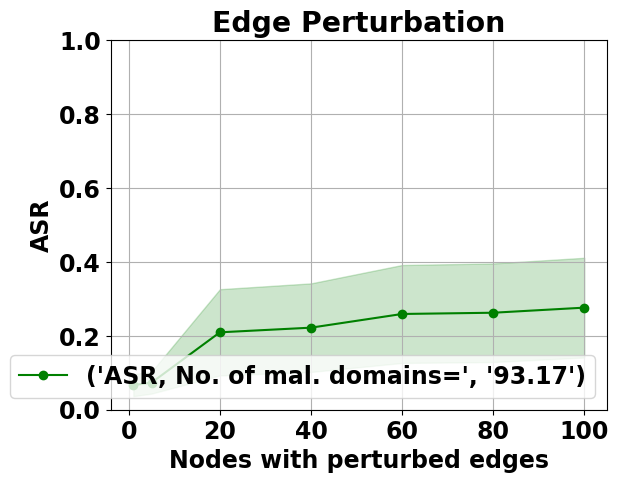

In [44]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_adj2_sampled_doms'):
    os.makedirs('RESULTS_adj2_sampled_doms')
plt.figure(facecolor='white')
plt.title("Edge Perturbation")
plt.xlabel("Nodes with perturbed edges") 
plt.ylabel("ASR") 

# plot the ASR:
m0, l0, u0=confid_measures(res_arr[:,0,:], Num)
plt.plot(val_nodes, m0,'-og', label=("ASR, No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc='lower right')
plt.grid()
plt.legend(loc='lower right')
plt.grid()
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150) 
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150) 
plt.show()


## Plot NFR

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [3.26666667 3.4        5.46666667 5.86666667 7.3        7.36666667
 7.8       ]
Sorted lower: [1.68799557 1.91131724 2.67221201 2.73999328 2.86295748 2.94234005
 3.15039599]
Sorted upper: [ 4.84533776  4.88868276  8.26112132  8.79099328 11.73704252 11.99334005
 12.44960401]


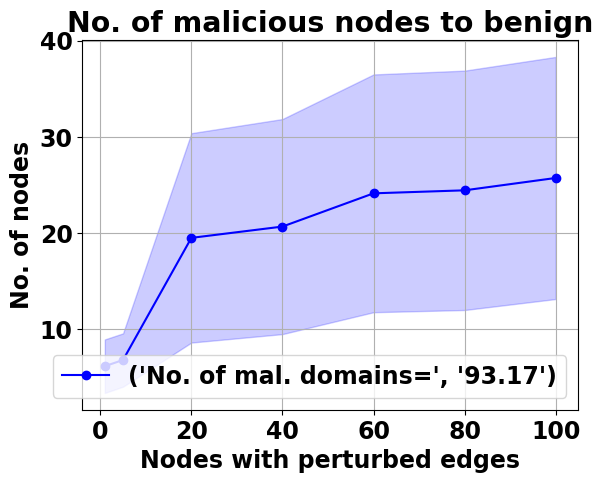

Shape of arr_tri: (30, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [3.26666667 3.4        5.46666667 5.86666667 7.3        7.36666667
 7.8       ]
Sorted lower: [1.68799557 1.91131724 2.67221201 2.73999328 2.86295748 2.94234005
 3.15039599]
Sorted upper: [ 4.84533776  4.88868276  8.26112132  8.79099328 11.73704252 11.99334005
 12.44960401]


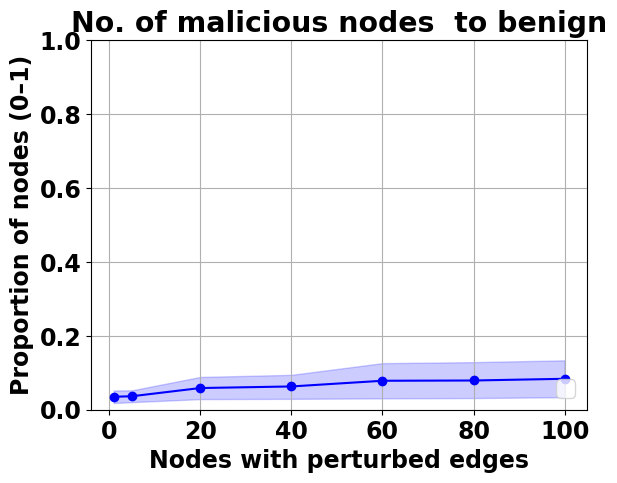

In [57]:
# NFR calculation using res_arr
m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

plt.figure(facecolor='white')
plt.title("No. of malicious nodes to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("No. of nodes")


plt.plot(val_nodes, m0*93.17, '-ob', label=("No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(val_nodes, l0*93.17, u0*93.17, color='blue', alpha=0.2)

plt.legend(loc='lower right')
plt.grid()

# Save plots
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.png'
plt.savefig(name, dpi=150)
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.pdf'
plt.savefig(name, dpi=150)

plt.show()

#with normalization
# Normalize NFR values
# Calculate NFR metrics using trial-level data
m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

# Normalize NFR values
m1_normalized = m1 / 93.17  # Mean normalized by total malicious nodes
l1_normalized = l1 / 93.17  # Lower bound normalized
u1_normalized = u1 / 93.17  # Upper bound normalized

# Plot with normalized y-axis
plt.figure(facecolor='white')
plt.title("No. of malicious nodes  to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("Proportion of nodes (0–1)")

# Plot the normalized NFR with confidence intervals
plt.fill_between(val_nodes, l1_normalized, u1_normalized, color='blue', alpha=0.2)
plt.plot(val_nodes, m1_normalized, '-ob')

# Set the y-axis range to match the normalized scale
plt.ylim(0, 1)

# Add grid and legend
plt.legend(loc='lower right')
plt.grid()

# Save the plot
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.png', dpi=150)
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.pdf', dpi=150)

# Show the plot
plt.show()



## Plot ROC

arr1 shape: (6, 7)
Shape of arr_tri: (1, 7)
Shape of arr_tri_mean: (7,)
Sorted mean: [0.09100993 0.14034925 0.24499134 0.24534476 0.24589731 0.26011277
 0.26620263]
Sorted lower: [0.09100993 0.14034925 0.24499134 0.24534476 0.24589731 0.26011277
 0.26620263]
Sorted upper: [0.09100993 0.14034925 0.24499134 0.24534476 0.24589731 0.26011277
 0.26620263]
Computed FPR (m3): [0.09100993 0.14034925 0.24499134 0.24534476 0.24589731 0.26011277
 0.26620263]


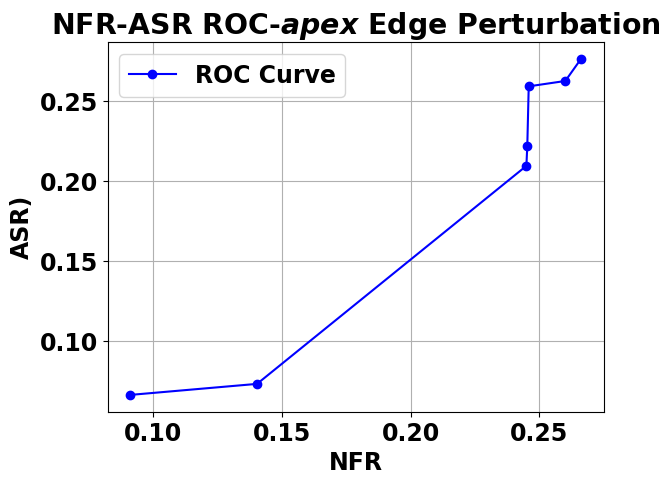

In [62]:
# Verify the shape of arr1
print("arr1 shape:", arr1.shape)

# Extract FPR values (3rd metric)
try:
    fpr_values = arr1[3, :]  # 3rd metric corresponds to FPR
    m3, l3, u3 = confid_measures(fpr_values.reshape(1, -1), 100)
    print("Computed FPR (m3):", m3)
except Exception as e:
    print("Error calculating m3 (FPR):", e)
    m3 = np.zeros_like(fpr_values)  # Fallback to zero array
    l3 = np.zeros_like(fpr_values)
    u3 = np.zeros_like(fpr_values)

# Assign TPR (ASR mean values) and FPR (FPR mean values)
tpr = m0  # True Positive Rate
fpr = m3  # False Positive Rate

# Plot the ROC Curve
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC-$\it{apex}$ Edge Perturbation")
plt.xlabel("NFR") 
plt.ylabel("ASR)") 
plt.plot(fpr, tpr, '-ob', label="ROC Curve")  # Plot FPR vs. TPR
plt.legend()
plt.grid()

# Save the plot
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.png'
plt.savefig(name, dpi=150)
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.pdf'
plt.savefig(name, dpi=150)

# Show the plot
plt.show()
